In [1]:
import json
import torch
import pandas as pd
import os.path as osp
import numpy as np
import itertools
from PIL import Image

from artemis.in_out.basics import unpickle_data, files_in_subdirs
from artemis.utils.vocabulary import Vocabulary
from artemis.in_out.neural_net_oriented import torch_load_model
from artemis.utils.visualization import visualize_attention_map_per_token
from artemis.evaluation.single_caption_per_image import apply_basic_evaluations

%load_ext autoreload
%autoreload 2

In [4]:
## USE YOUR PATHS in cell below.
## NOTE. I will update this notebook with better! help messages in April.

In [13]:
# top-image dir
wiki_art_img_dir = '/home/optas/DATA/Images/Wiki-Art/rescaled_max_size_to_600px_same_aspect_ratio'

# output of preprocess_artemis_data.py
references_file = '/home/optas/DATA/OUT/artemis/preprocessed_data/for_neural_nets/artemis_gt_references_grouped.pkl'

# to compute the emotion-alignment you need a text2emo classifier, provide one.
text2emo_path = '/home/optas/DATA/OUT/artemis/neural_nets/txt_to_emotion/lstm_based/best_model.pt'

# this is what is the vocabulary used by the text2emo classifier which in our case is equal to what was 
# used by the neural speaker(though this is not necessary as the input of the text2emo from the speaker 
# is human sentences, so it could decode them anyway.
# this is also generated as an ouput of preprocess_artemis_data.py
vocab_path = '/home/optas/DATA/OUT/artemis/preprocessed_data/for_neural_nets/vocabulary.pkl'

# the file with the samples
# (most likely this was produced by calling sample_speaker.py)
sampled_captions_file = '/home/optas/DATA/OUT/artemis/neural_nets/speakers/nearest_neighbor/samples_from_best_model_test_split.pkl'
sampled_captions_file = '/home/optas/DATA/OUT/artemis/neural_nets/speakers/default_training/03-16-2021-22-21-45/samples_from_best_model_test_split.pkl'
sampled_captions_file = '/home/optas/DATA/OUT/artemis/neural_nets/speakers/emo_grounding/03-17-2021-20-32-19/samples_from_best_model_test_split.pkl'

split = 'test' # or val, up to you!
gpu_id = 0

# the evaluation of the longest-common-subsequence is quite slow -- so we sub-sampled the data:
default_lcs_sample = [25000, 800]
# First integer (25000) = number of training (gt) sentences to subsample from all training
# Secong integer (800)  = number of sample sentences to subsample from all generations

In [14]:
#
# Load grouped GT references, Vocab & image2emotion net (for Emo-alignment)
#

gt_data = next(unpickle_data(references_file))

train_utters = gt_data['train']['references_pre_vocab']
train_utters = list(itertools.chain(*train_utters))  # undo the grouping per artwork to a single large list
print('Training Utterances', len(train_utters))
unique_train_utters = set(train_utters)
print('Unique Training Utterances', len(unique_train_utters))

# now focus on the data (split) that you created captions for
gt_data = gt_data[split]
print('Images Captioned', len(gt_data))

device = torch.device("cuda:" + str(gpu_id))
txt2emo_clf = torch_load_model(text2emo_path, map_location=device)

txt2emo_vocab = Vocabulary.load(vocab_path)
print('vocab size', len(txt2emo_vocab))

Training Utterances 338777
Unique Training Utterances 338144
Images Captioned 7933
vocab size 14469


In [15]:
evaluation_methods = {'bleu', 'meteor', 'rouge', 'emo_alignment', 'metaphor'}

# Note. You can also add "lcs". With the samples we used (25000 training, 800, samples) 
# it will take take 35 mins to compute.
# evaluation_methods.update({'lcs'}) # Uncomment to add it.

# Note. You can also add SPICE will take some minutes the first time; it will speed up due to caching afterwards.
# evaluation_methods.update({'spice'}) # Uncomment to add it.

# Note. You can also add CIDER. That's be design not a very good metric; since we have a lot of variance! in the gt.
# evaluation_methods.update({'cider'}) # Uncomment to add it.

print(evaluation_methods)

{'emo_alignment', 'bleu', 'meteor', 'metaphor', 'rouge'}


In [16]:
def print_out_some_basic_stats(captions):
    """ Helper function -- to print basic statistics of sampled generations
    Input: captions dataframe with column names caption
    """
    print('Some basic statistics:')
    mean_length = captions.caption.apply(lambda x: len(x.split())).mean()
    print(f'average length of productions {mean_length:.4}')
    unique_productions = len(captions.caption.unique()) / len(captions)
    print(f'percent of distinct productions {unique_productions:.2}')
    maximizer = captions.caption.mode()
    print(f'Most common production "{maximizer.iloc[0]}"')
    n_max = sum(captions.caption == maximizer.iloc[0]) 
    print(f'Most common production appears {n_max} times -- {n_max/ len(captions):.2} frequency.')
    u_tokens = set()
    captions.caption.apply(lambda x: [u_tokens.add(i) for i in x.split()]);
    print(f'Number of distinct tokens {len(u_tokens)}')

In [17]:
saved_samples = next(unpickle_data(sampled_captions_file))

for sampling_config_details, captions, attn in saved_samples:  # you might have sampled under several sampling configurations
    print('Sampling Config:', sampling_config_details)        
    
    print('\nSome Random Samples:')    
    rs = captions.sample(min(len(captions), 5))[['caption', 'grounding_emotion']]        
    for _, row in rs.iterrows():
        if row.grounding_emotion is not None:
            print(row.grounding_emotion.capitalize(), end=' --- ')
        print(row.caption)
    
    print()            
    print_out_some_basic_stats(captions)
    print()
    
    merged = pd.merge(gt_data, captions)  # this ensures proper order of captions to gt (via accessing merged.captions)
    hypothesis = merged.caption
    references = merged.references_pre_vocab # i.e., use references that do not have <UNK>
    ref_emotions = merged.emotion

    metrics_eval = apply_basic_evaluations(hypothesis, references, ref_emotions, txt2emo_clf, txt2emo_vocab, 
                                           nltk_bleu=False, lcs_sample=default_lcs_sample,
                                           train_utterances=unique_train_utters,
                                           methods_to_do=evaluation_methods)

    print(pd.DataFrame(metrics_eval))
    print()

Sampling Config: {'sampling_rule': 'beam', 'temperature': 0.3, 'beam_size': 5, 'max_utterance_len': 30, 'drop_unk': True, 'drop_bigrams': True}

Some Random Samples:
Fear --- the colors are dark and the figures are distorted
Amusement --- the colors are bright and the shapes are fun
Awe --- the woman is beautiful and her body is very smooth
Contentment --- the colors are very warm and calming
Amusement --- the man looks like he is having a good time

Some basic statistics:
average length of productions 10.05
percent of distinct productions 0.46
Most common production "the man looks like he is thinking about something"
Most common production appears 195 times -- 0.025 frequency.
Number of distinct tokens 1078

BLEU: done
COCO-based-metrics: done
EMO-ALIGN: done
Metaphor-like expressions: Done
               metric      mean       std
0              BLEU-0  0.520229  0.159781
1              BLEU-1  0.280354  0.183203
2              BLEU-2  0.146229  0.141740
3              BLEU-3  0.0788

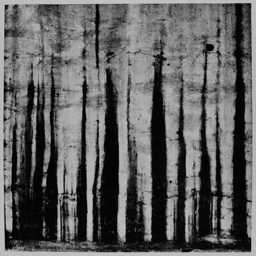

0 the dark colors and the lines make me feel like i am trapped in a horror movie


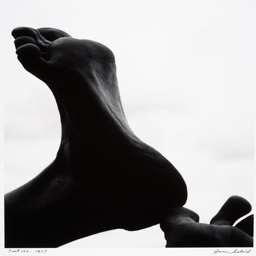

1 the shape of the hand is very interesting


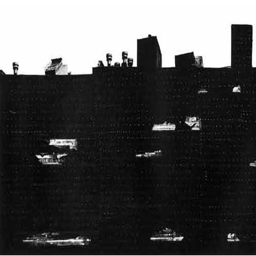

2 i am confused as to what this is supposed to be


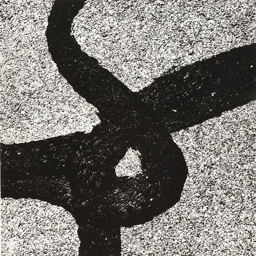

3 the black figure looks like a monster


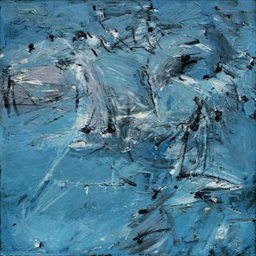

4 the blue and white colors are very calming


In [25]:
## Bonus see some Images with their caption.
max_results = 5
for i, row in captions.iterrows():
    if i >= max_results:
        break
    img_file = osp.join(wiki_art_img_dir, row['art_style'], row['painting'] + '.jpg')
    display(Image.open(img_file).resize((256, 256)))
    print(i, row['caption'])    

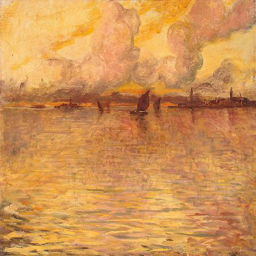

the clouds look like they are glowing in the sky


/home/optas/Git_Repos/artemis_temp/artemis_temp/utils/visualization.py:129: MatplotlibDeprecationWarning:

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.



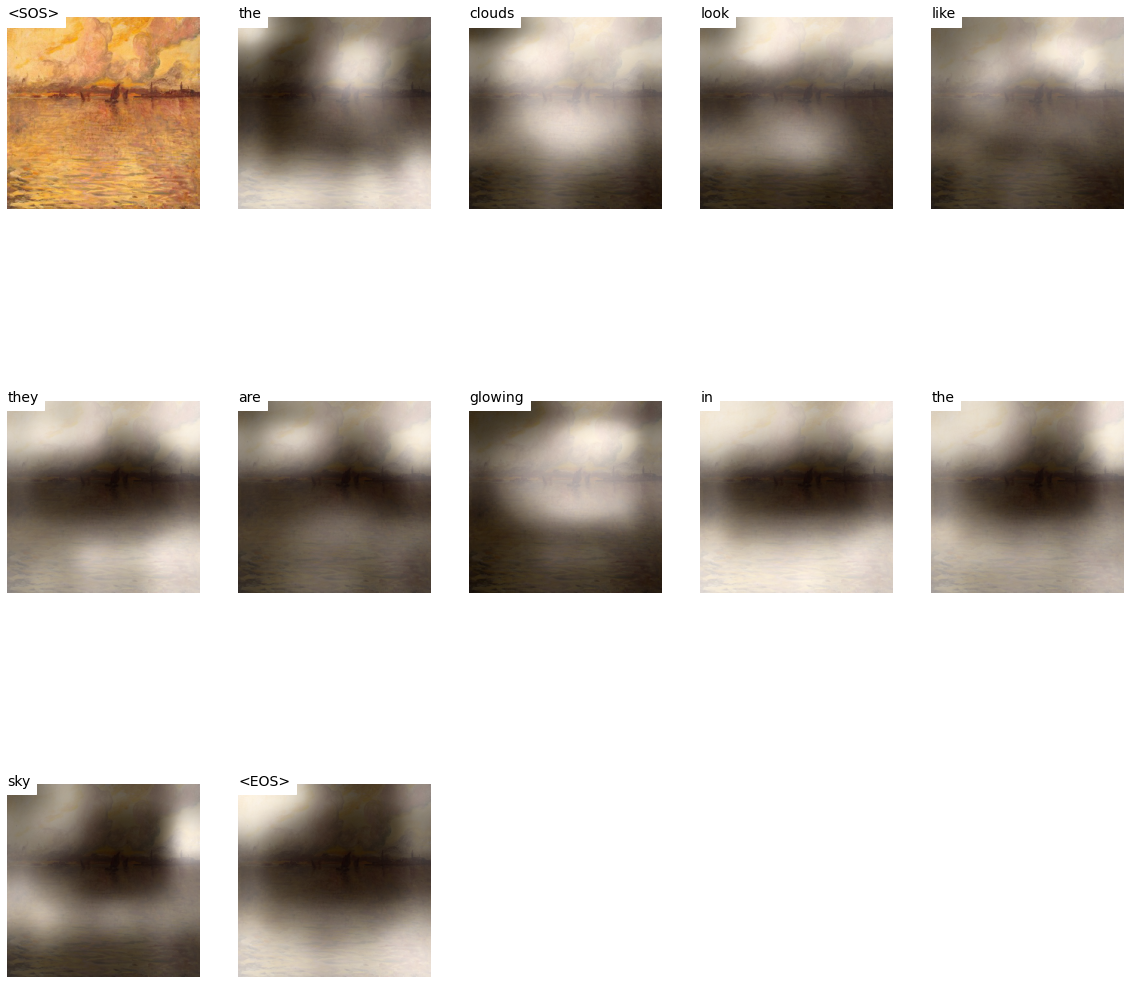

In [26]:
## Bonus see some attention Images.
random_id = np.random.randint(len(captions))
row = captions.iloc[random_id]
img_file = osp.join(wiki_art_img_dir, row['art_style'], row['painting'] + '.jpg')
image = Image.open(img_file).resize((256, 256))
display(image)

print(row['caption'])

MAX_LEN = 30
pixel_upscale = 32

tokens = ['<SOS>'] + row['caption'].split() +  ['<EOS>']
tokens = tokens[:MAX_LEN]

attention_map = np.array(attn[random_id][:len(tokens)])
visualize_attention_map_per_token(image, tokens, attention_map, pixel_upscale, smooth_attention=True)